# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

**Ответ:** В среднем 0.1, поскольку сеть нетренирована. Флуктуации обеспечены рандомным распределением весов сети.

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.217057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.157437, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.115648, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287707, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.176635, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.070778, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.389343, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201810, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268138, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.177243, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.188959, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288565, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324022, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.376680, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.181966, Train acc

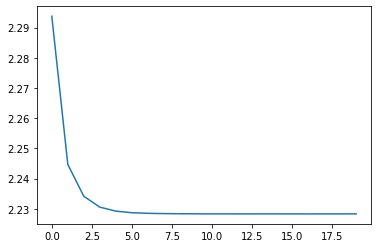

In [10]:
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.250718, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.369508, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209910, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258537, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.188416, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.205064, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.126148, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325751, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320998, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.175592, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265976, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.363186, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.131519, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.410504, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228590, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.321504, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305573, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315005, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.249502, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.255664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300977, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243300, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259131, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240870, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256889, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305861, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.215956, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266154, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.247150, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.351618, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.318467, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.291136, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341864, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302463, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.319034, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.235521, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.170412, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.144598, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.000302, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.842682, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.238035, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.616099, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.203432, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.902569, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.637197, Train acc

Loss: 1.381779, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.321666, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.138238, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.135899, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.166023, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.297579, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.133557, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.212286, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.282922, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.026195, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.237881, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.280440, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.126200, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.263944, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.136968, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.371337, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

**Комментарий**: Перед тем как устроить перебор по всей сетке параметров, подберем на глаз: поставим Momentum, увеличим число нейронов в скрытом слое, поставим не такую большую регуляризацию. В случае успеха не придется делать перебор.

UPD: Сработало.

In [22]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 300, reg = 1e-5)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.303635, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.293074, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.265773, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.208682, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.037252, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 1.885547, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.887529, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.115065, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 1.874202, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.605316, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.537099, Train accuracy: 0.533333, val accuracy: 0.133333
Loss: 1.184568, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.842651, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.958606, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.295460, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.699491, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [15]:
# Let's train the best one-hidden-layer network we can

# Best parameters for now are (0.78, 50, 25, 200, 0.9, 0.8, 0.001, 0.1)
# best_parameters = (val_history[len(val_history)-1], batch, epoch, laysize, decay, moment, reg, rate)

learning_rates = [1e-1, 1e-2]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [64, 128, 256]
batch_size = [64, 128]
num_epochs = 16

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()
    
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.231223, Train accuracy: 0.334889, val accuracy: 0.336000
Loss: 2.242964, Train accuracy: 0.435111, val accuracy: 0.452000
Loss: 1.741416, Train accuracy: 0.609333, val accuracy: 0.592000
Loss: 1.532193, Train accuracy: 0.622000, val accuracy: 0.586000
Loss: 1.458880, Train accuracy: 0.641556, val accuracy: 0.608000
Loss: 1.512123, Train accuracy: 0.662000, val accuracy: 0.623000
Loss: 1.611035, Train accuracy: 0.625222, val accuracy: 0.615000
Loss: 1.564311, Train accuracy: 0.630667, val accuracy: 0.589000
Loss: 1.360436, Train accuracy: 0.618778, val accuracy: 0.589000
Loss: 1.324650, Train accuracy: 0.624333, val accuracy: 0.582000
Loss: 1.408848, Train accuracy: 0.636778, val accuracy: 0.595000
Loss: 1.657688, Train accuracy: 0.666333, val accuracy: 0.633000
Loss: 1.259272, Train accuracy: 0.662222, val accuracy: 0.627000
Loss: 1.824181, Train accuracy: 0.659667, val accuracy: 0.612000
Loss: 1.327270, Train accuracy: 0.676667, val accuracy: 0.634000
Loss: 1.663748, Train acc

Loss: 0.636031, Train accuracy: 0.787889, val accuracy: 0.682000
Loss: 1.897811, Train accuracy: 0.338778, val accuracy: 0.350000
Loss: 1.567589, Train accuracy: 0.585444, val accuracy: 0.571000
Loss: 0.926535, Train accuracy: 0.620556, val accuracy: 0.614000
Loss: 1.220348, Train accuracy: 0.591000, val accuracy: 0.552000
Loss: 1.280089, Train accuracy: 0.657667, val accuracy: 0.625000
Loss: 1.040229, Train accuracy: 0.672667, val accuracy: 0.636000
Loss: 1.293408, Train accuracy: 0.688222, val accuracy: 0.635000
Loss: 1.270849, Train accuracy: 0.726889, val accuracy: 0.672000
Loss: 1.062738, Train accuracy: 0.716556, val accuracy: 0.636000
Loss: 0.886852, Train accuracy: 0.739889, val accuracy: 0.671000
Loss: 0.536044, Train accuracy: 0.704222, val accuracy: 0.631000
Loss: 0.743393, Train accuracy: 0.722111, val accuracy: 0.659000
Loss: 0.880421, Train accuracy: 0.736889, val accuracy: 0.648000
Loss: 1.609742, Train accuracy: 0.723667, val accuracy: 0.638000
Loss: 1.305231, Train acc

Loss: 1.603230, Train accuracy: 0.510556, val accuracy: 0.512000
Loss: 1.530712, Train accuracy: 0.546222, val accuracy: 0.546000
Loss: 2.268336, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.238269, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.195728, Train accuracy: 0.204667, val accuracy: 0.218000
Loss: 2.073342, Train accuracy: 0.274556, val accuracy: 0.280000
Loss: 1.836626, Train accuracy: 0.347000, val accuracy: 0.352000
Loss: 1.823415, Train accuracy: 0.437111, val accuracy: 0.429000
Loss: 1.508246, Train accuracy: 0.482222, val accuracy: 0.487000
Loss: 1.198392, Train accuracy: 0.566778, val accuracy: 0.558000
Loss: 1.529996, Train accuracy: 0.605222, val accuracy: 0.599000
Loss: 1.391205, Train accuracy: 0.645556, val accuracy: 0.628000
Loss: 1.170167, Train accuracy: 0.669222, val accuracy: 0.663000
Loss: 1.327962, Train accuracy: 0.685556, val accuracy: 0.673000
Loss: 1.161697, Train accuracy: 0.702889, val accuracy: 0.684000
Loss: 1.012636, Train acc

Loss: 1.306304, Train accuracy: 0.531556, val accuracy: 0.529000
Loss: 1.323790, Train accuracy: 0.571556, val accuracy: 0.550000
Loss: 1.270325, Train accuracy: 0.597778, val accuracy: 0.579000
best validation accuracy achieved: 0.711000


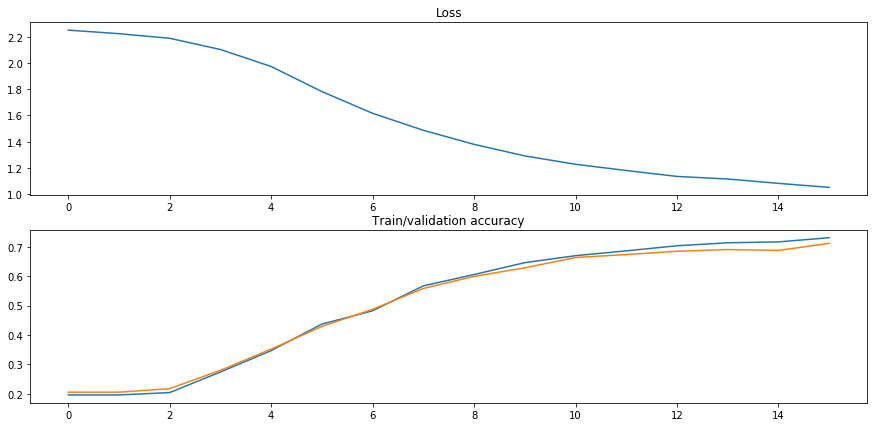

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [17]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.648000
